In [1]:
import pandas as pd
from math import sqrt
import numpy as np
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
import time
import cbpro
import csv
import json
import shutil
import os
start_time = time.time()
end_time = start_time-(86400*300)
public_client = cbpro.PublicClient()
public_client.get_product_historic_rates('ETH-USD')
data = public_client.get_product_historic_rates('ETH-USD', granularity=60)

In [3]:
data1 = pd.DataFrame(data)
print(data1)

              0       1       2       3       4           5
0    1559924340  250.16  250.75  250.21  250.74  332.721147
1    1559924280  250.00  250.30  250.04  250.30   39.249033
2    1559924220  250.03  250.33  250.08  250.16   16.204350
3    1559924160  250.01  250.60  250.56  250.01  162.869219
4    1559924100  250.13  250.59  250.14  250.59   29.500758
5    1559924040  249.99  250.58  249.99  250.20  417.069577
6    1559923980  249.66  249.99  249.66  249.98   76.949044
7    1559923920  249.42  249.67  249.45  249.67  304.359648
8    1559923860  249.26  249.48  249.26  249.26   27.147462
9    1559923800  249.21  249.38  249.32  249.26   34.904803
10   1559923740  249.27  249.38  249.27  249.37   46.210915
11   1559923680  249.05  249.28  249.27  249.28  206.930699
12   1559923620  249.27  249.51  249.51  249.28  123.425380
13   1559923560  249.51  249.56  249.54  249.51   11.203243
14   1559923500  249.36  249.56  249.42  249.53  117.618559
15   1559923440  249.11  249.42  249.11 

In [4]:
data1 = data1.iloc[::-1]
data1 = data1.reset_index()
data1 = data1.drop('index',axis=1)
print(data1)

              0       1       2       3       4           5
0    1559906340  248.64  248.90  248.90  248.79  273.116895
1    1559906400  248.66  248.70  248.70  248.69   56.926701
2    1559906460  248.59  248.60  248.60  248.59   27.917871
3    1559906520  248.60  248.60  248.60  248.60    1.164183
4    1559906580  248.59  248.60  248.59  248.60   13.057198
5    1559906640  248.59  248.70  248.60  248.70   14.169616
6    1559906700  248.66  248.93  248.68  248.81   35.690834
7    1559906760  248.84  248.91  248.89  248.84    3.142967
8    1559906820  248.60  248.76  248.76  248.61   45.236164
9    1559906880  248.60  248.61  248.60  248.60  108.301150
10   1559906940  248.47  248.87  248.61  248.87   46.474527
11   1559907000  248.33  248.66  248.59  248.37   27.348382
12   1559907060  248.50  248.51  248.50  248.50   17.868274
13   1559907120  248.35  248.57  248.51  248.36   18.511744
14   1559907180  248.21  248.35  248.35  248.30   42.860926
15   1559907240  248.10  248.29  248.21 

In [5]:
data1.to_csv('data.csv')

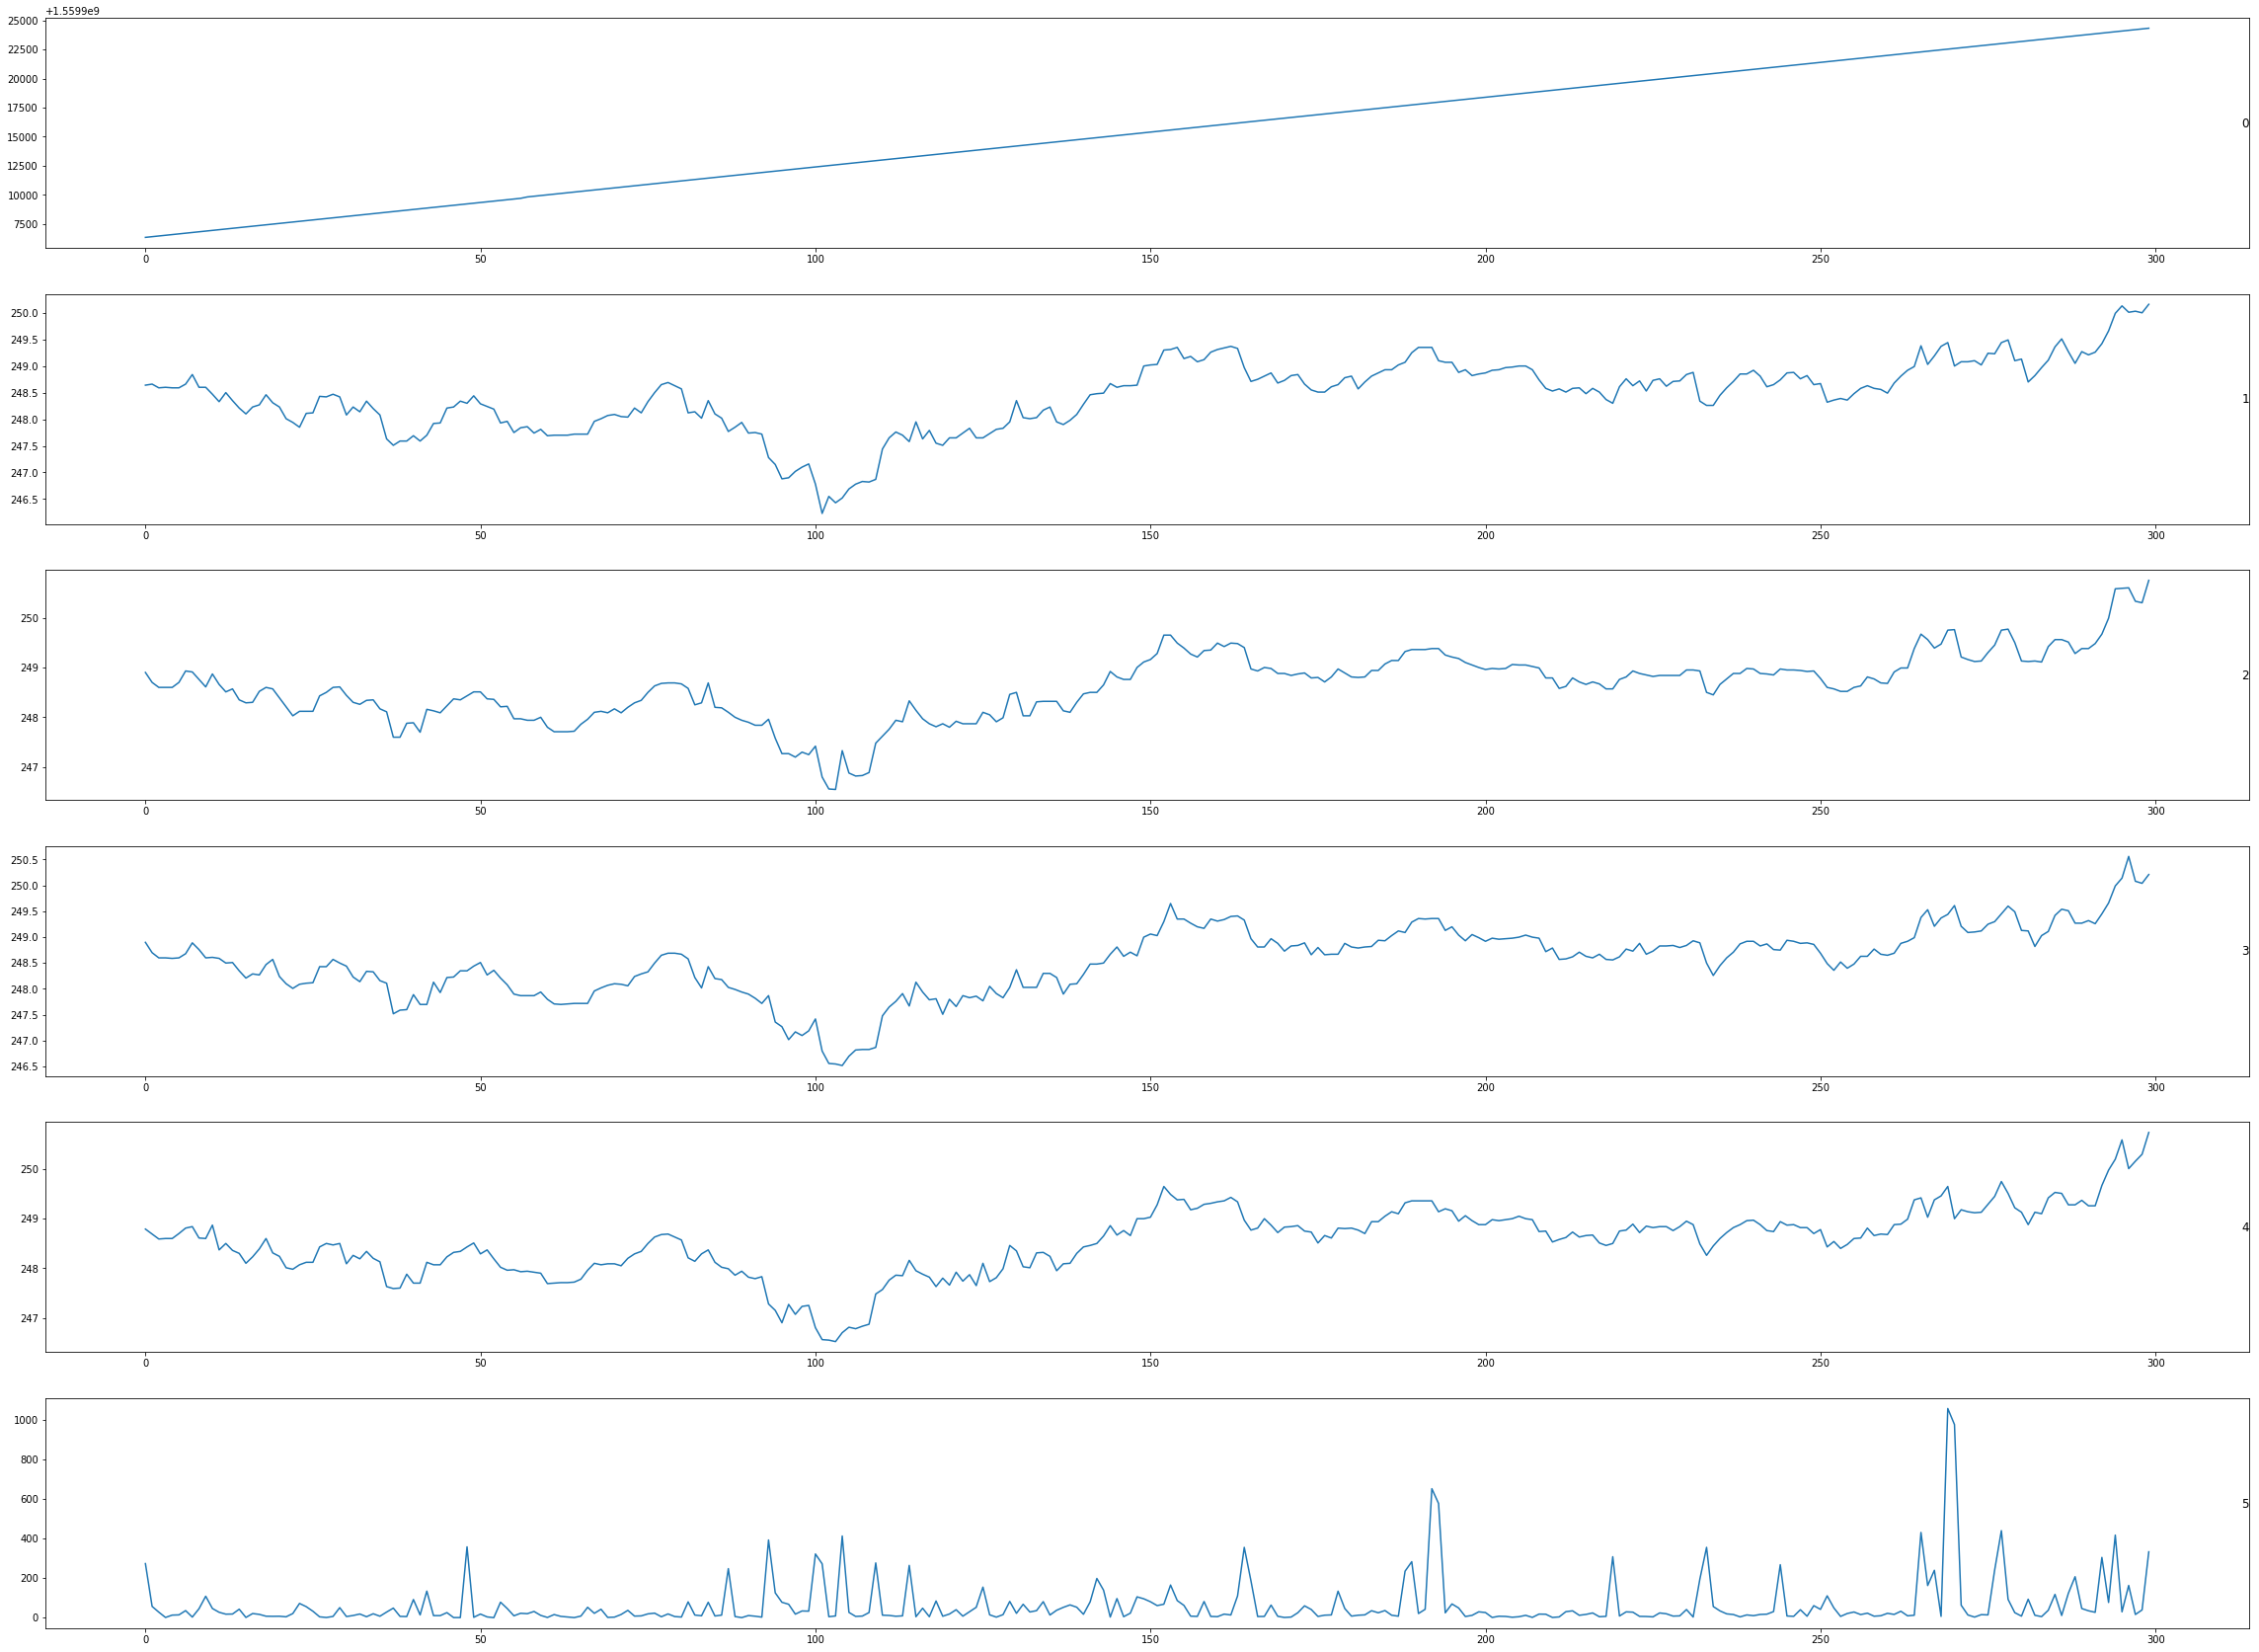

In [6]:
from pandas import read_csv
from matplotlib import pyplot
%matplotlib inline
# load dataset
dataset = read_csv('data.csv', header=0, index_col=0)
values = dataset.values

# specify columns to plot
groups = [0,1,2,3,4,5]
i = 1
# plot each column
pyplot.figure(figsize=(40,30))
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [7]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
print(reframed.head(30))

    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)
1    0.000000   0.613232   0.559521   0.589108   0.537914   0.258393  0.007812
2    0.007812   0.618320   0.511902   0.539604   0.514217   0.053696  0.007812
3    0.007812   0.600506   0.488094   0.514854   0.490520   0.026230  0.015625
4    0.015625   0.603054   0.488094   0.514854   0.492893   0.000898  0.015625
5    0.015625   0.600506   0.488094   0.512375   0.492893   0.012159  0.023438
6    0.023438   0.600506   0.511902   0.514854   0.516586   0.013212  0.023438
7    0.023438   0.618320   0.566662   0.534653   0.542652   0.033589  0.031250
8    0.031250   0.664120   0.561905   0.586636   0.549763   0.002772  0.031250
9    0.031250   0.603054   0.526188   0.554455   0.495262   0.042627  0.031250
10   0.031250   0.603054   0.490475   0.514854   0.492893   0.102340  0.031250
11   0.031250   0.569973   0.552380   0.517326   0.556870   0.043800  0.031250
12   0.031250   0.534351   0.502380   0.512375   0.4

In [14]:
# split into train and test sets
values = reframed.values
n_train_hours = 1270
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(299, 1, 6) (299,) (0, 1, 6) (0,)


Train on 299 samples, validate on 0 samples
Epoch 1/50
 - 3s - loss: 0.4974
Epoch 2/50
 - 0s - loss: 0.4787
Epoch 3/50
 - 0s - loss: 0.4577
Epoch 4/50
 - 0s - loss: 0.4327
Epoch 5/50
 - 0s - loss: 0.4018
Epoch 6/50
 - 0s - loss: 0.3638
Epoch 7/50
 - 0s - loss: 0.3177
Epoch 8/50
 - 0s - loss: 0.2647
Epoch 9/50
 - 0s - loss: 0.2120
Epoch 10/50
 - 0s - loss: 0.1611
Epoch 11/50
 - 0s - loss: 0.1692
Epoch 12/50
 - 0s - loss: 0.1980
Epoch 13/50
 - 0s - loss: 0.2066
Epoch 14/50
 - 0s - loss: 0.1942
Epoch 15/50
 - 0s - loss: 0.1792
Epoch 16/50
 - 0s - loss: 0.1710
Epoch 17/50
 - 0s - loss: 0.1665
Epoch 18/50
 - 0s - loss: 0.1641
Epoch 19/50
 - 0s - loss: 0.1635
Epoch 20/50
 - 0s - loss: 0.1624
Epoch 21/50
 - 0s - loss: 0.1585
Epoch 22/50
 - 0s - loss: 0.1533
Epoch 23/50
 - 0s - loss: 0.1470
Epoch 24/50
 - 0s - loss: 0.1434
Epoch 25/50
 - 0s - loss: 0.1417
Epoch 26/50
 - 0s - loss: 0.1382
Epoch 27/50
 - 0s - loss: 0.1340
Epoch 28/50
 - 0s - loss: 0.1304
Epoch 29/50
 - 0s - loss: 0.1275
Epoch 30

KeyError: 'val_loss'

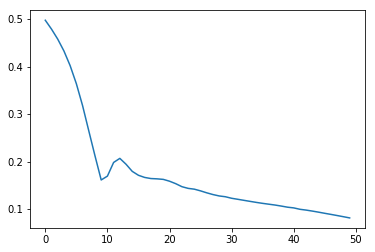

In [15]:
# design network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [16]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
pyplot.plot(inv_yhat)
pyplot.show()

In [ ]:
pyplot.plot(inv_y)
pyplot.show()